In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ['CUDA'] = '/usr/local/cuda-12'
os.environ['PATH'] = '/usr/local/cuda-12/bin${PATH:+:${PATH}}'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import argparse
import itertools
import pickle as pkl
from functools import partial

import jax.numpy as jnp
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from jax import vmap, jit

convolve = jit(vmap(partial(jnp.convolve, mode='valid'), in_axes=(1, None)))
ew_er = 'out/ENEMY_WALK.out'
ew_simple_model = 'out/EW_simple_model.out'
ew_VQVAE_simple_model = 'out/EW_VQ_VAE_simple_model.out'
ew_VQVAE_simple_model_no_emb = 'out/EW_VQ_VAE_simple_model_mi.out'
ew_VQVAE_simple_model_prior = 'out/EW_VQ_VAE_simple_model_prior.out'
ew_VQVAE_simple_model_env_q = 'out/EW_VQ_VAE_simple_model_env_q.out'
ew_VQVAE_simple_model_env_q50 = 'out/EW_VQ_VAE_simple_model_env_q50.out'
default_data = [ew_er, ew_simple_model, ew_VQVAE_simple_model, ew_VQVAE_simple_model_no_emb, ew_VQVAE_simple_model_prior,
                ew_VQVAE_simple_model_env_q, ew_VQVAE_simple_model_env_q50]

def plot_metric(metric, data=default_data, frequency=1, window=1,):
    palette = itertools.cycle(sns.color_palette())

    handles = []

    for d in data:
        color = next(palette)
        with open(d, 'rb') as f:
            data = pkl.load(f)["metrics"]
        if metric not in data.keys():
            continue
        values = jnp.asarray(data[metric])[::frequency, :]
        times = jnp.transpose(jnp.asarray([data["eval_times"][::frequency]] * values.shape[1]))

        if window > 1:
            values = convolve(values, np.ones(window) / window)
            times = convolve(times, np.ones(window) / window)

        handles += [mpatches.Patch(color=color, label=d)]

        values = values.flatten()
        times = times.flatten()
        data_frame = pd.DataFrame({metric: values, "time": times})
        sns.lineplot(x="time", y=metric, data=data_frame, color=color)
    plt.legend(handles=handles)
    plt.grid()
    plt.show()

In [27]:
# plot_metric('reward_rates')

In [28]:
with open(ew_VQVAE_simple_model_prior, 'rb') as f:
    data = pkl.load(f)["metrics"]
data.keys()

dict_keys(['reward_rates', 'eval_times', 'avg_Q', 'avg_reward', 'embedding_prior_loss', 'mi_action_acc', 'mi_loss', 'next_obs_accuracy', 'next_obs_loss', 'non_terminal', 'non_terminal_correct_count', 'reward_loss', 'terminal', 'terminal_correct_count', 'termination_loss'])

In [29]:
data['next_obs_accuracy'][0].shape

(10,)

reward_rates :


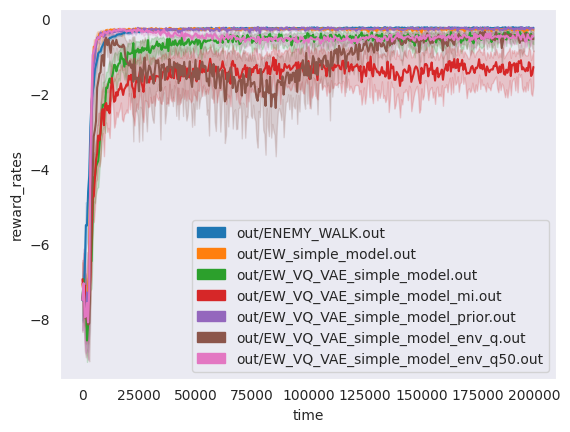

avg_Q :


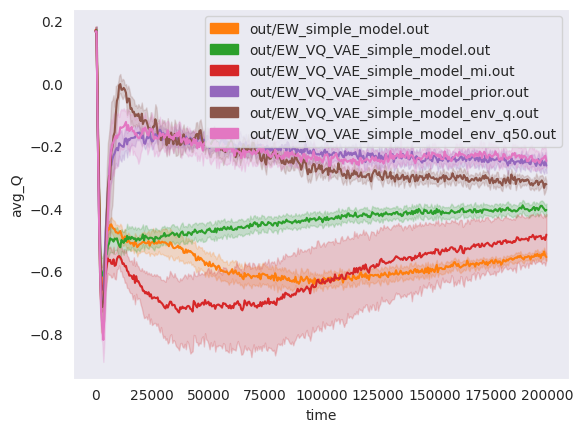

avg_reward :


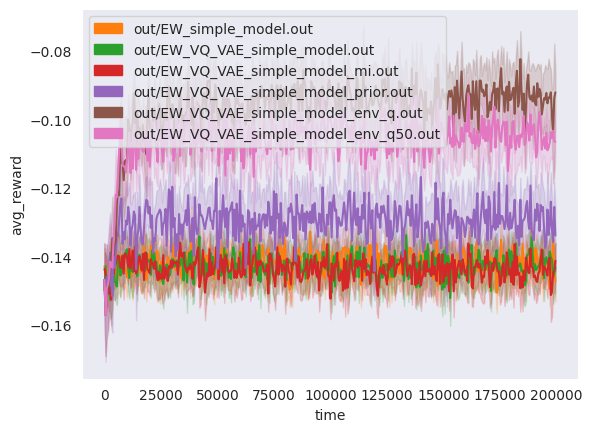

embedding_prior_loss :


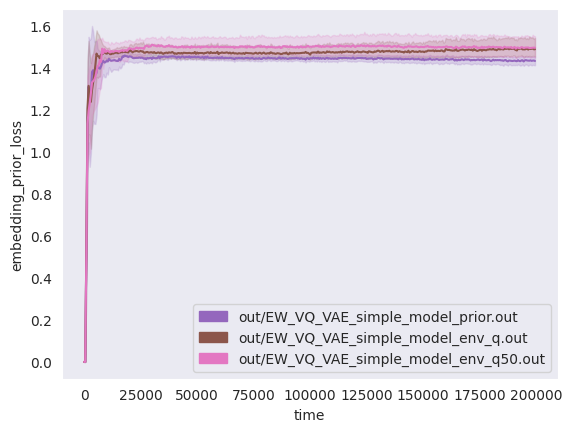

mi_action_acc :


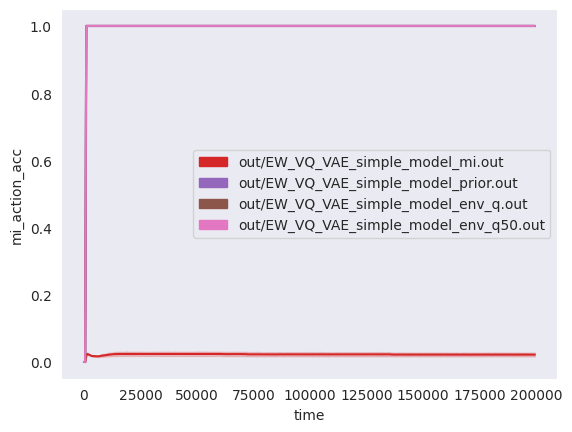

mi_loss :


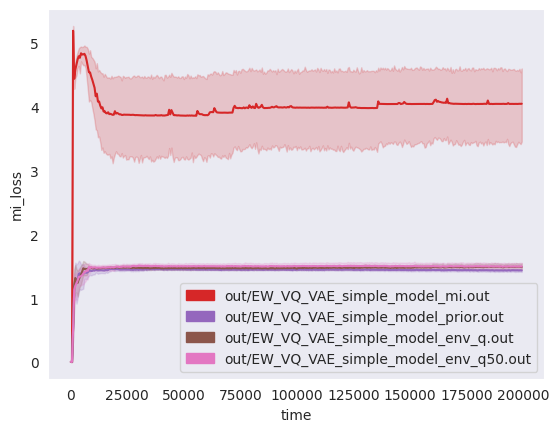

next_obs_accuracy :


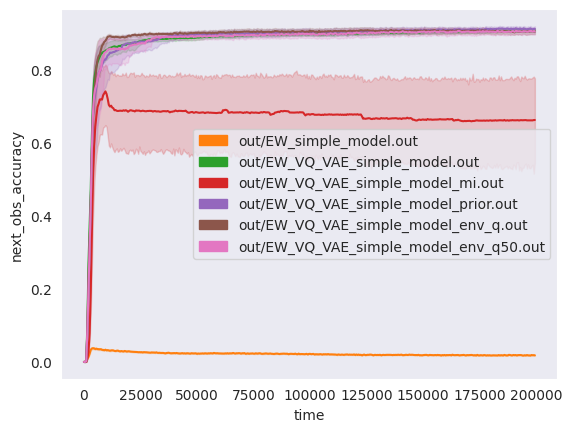

next_obs_loss :


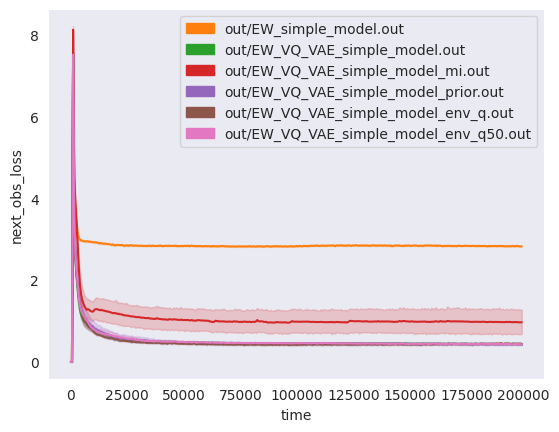

non_terminal :


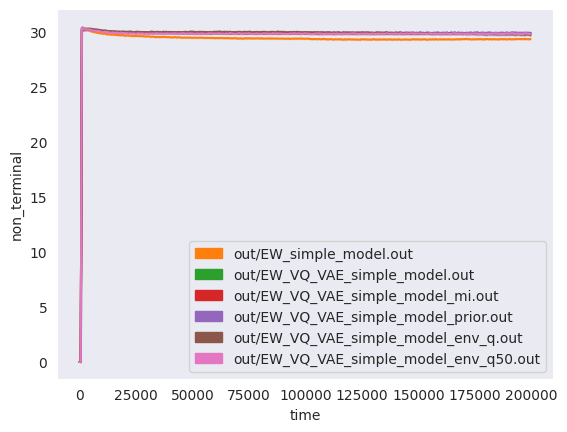

non_terminal_correct_count :


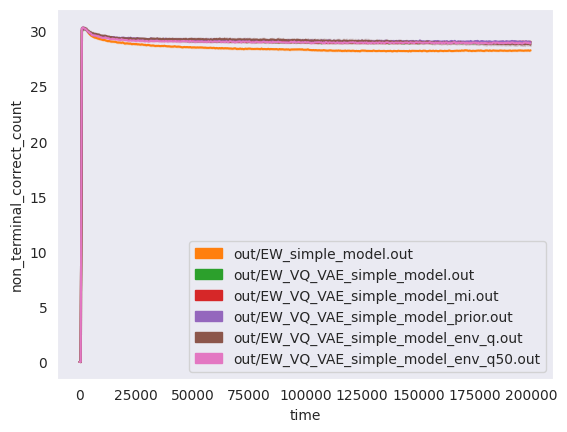

reward_loss :


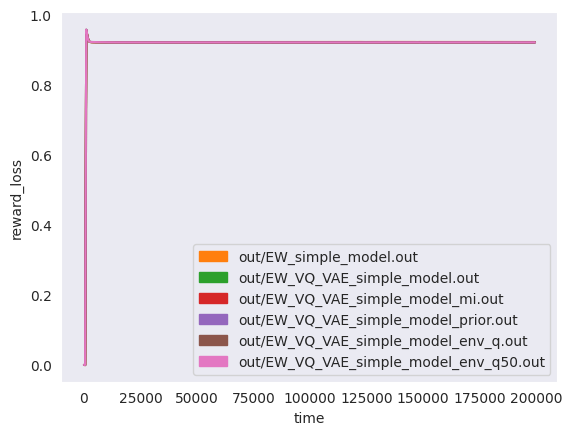

terminal :


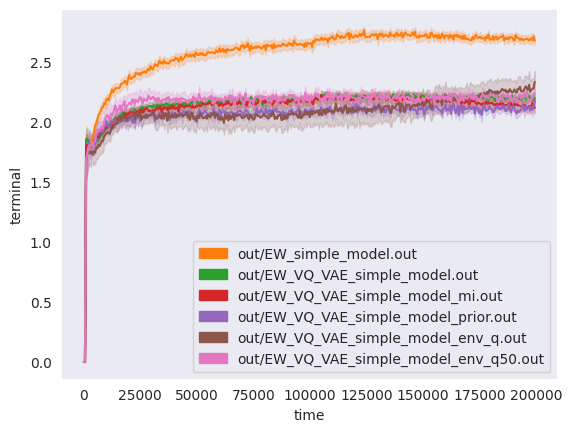

terminal_correct_count :


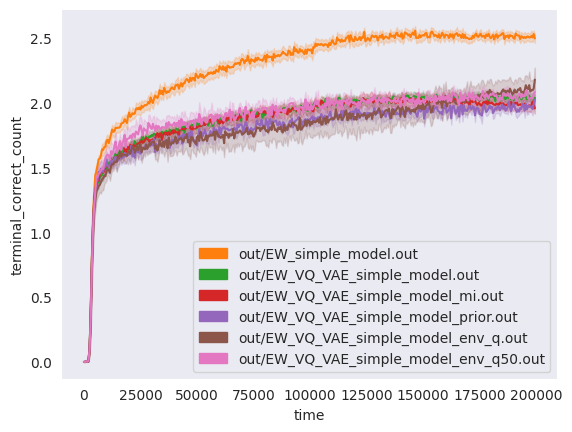

termination_loss :


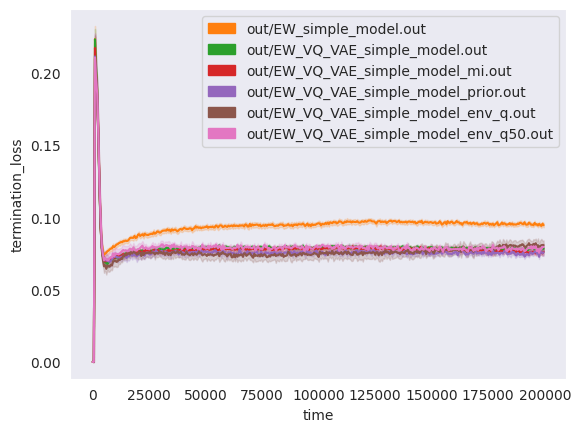

In [30]:
for key in data.keys():
    if key == 'eval_times':
        continue
    print(key, ':')
    plot_metric(key)